# DS3010: Introduction to Machine Learning Lab – Week 10
## **Hidden Markov Model (HMM)**
**Name:** Parv Patel  
**Roll No:** 142301041  
**Lab:** Week 10 – Hidden Markov Model

---

### Objective
To model daily weather patterns using a Hidden Markov Model (HMM) and perform the following tasks:
- Define HMM parameters (states, observations, transition, emission, and initial probabilities).
- Compute sequence probabilities using the Forward algorithm.
- Find the most likely hidden state sequence using the Viterbi algorithm.
- Simulate daily weather sequences.
- Compare two models (normal vs stable weather).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from collections import Counter

## 1. Model Definition

In [2]:
states = ['Sunny', 'Cloudy', 'Rainy']
observations = ['Dry', 'Damp', 'Wet']

A = np.array([
    [0.75, 0.20, 0.05],
    [0.25, 0.50, 0.25],
    [0.05, 0.25, 0.70]
])

B = np.array([
    [0.70, 0.25, 0.05],
    [0.30, 0.50, 0.20],
    [0.05, 0.25, 0.70]
])

pi = np.array([0.6, 0.3, 0.1])

print("Transition Matrix (A):\n", A)
print("\nEmission Matrix (B):\n", B)
print("\nInitial Probabilities (pi):\n", pi)

Transition Matrix (A):
 [[0.75 0.2  0.05]
 [0.25 0.5  0.25]
 [0.05 0.25 0.7 ]]

Emission Matrix (B):
 [[0.7  0.25 0.05]
 [0.3  0.5  0.2 ]
 [0.05 0.25 0.7 ]]

Initial Probabilities (pi):
 [0.6 0.3 0.1]


## 2. HMM Construction

In [3]:
# Construct HMM using MultinomialHMM
model = hmm.MultinomialHMM(n_components=3, random_state=42, n_iter=1, n_trials=1)

model.startprob_ = pi.copy()
model.transmat_ = A.copy()
model.emissionprob_ = B.copy()

print("Start probabilities:", model.startprob_)
print("Transition matrix:\n", model.transmat_)
print("Emission probabilities:\n", model.emissionprob_)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Start probabilities: [0.6 0.3 0.1]
Transition matrix:
 [[0.75 0.2  0.05]
 [0.25 0.5  0.25]
 [0.05 0.25 0.7 ]]
Emission probabilities:
 [[0.7  0.25 0.05]
 [0.3  0.5  0.2 ]
 [0.05 0.25 0.7 ]]


## 3. Sequence Probability (Forward Algorithm)

In [4]:
# Observation sequence
obs_seq = ['Dry', 'Damp', 'Wet', 'Wet', 'Damp']
obs_to_idx = {o: i for i, o in enumerate(observations)}

# Convert to one-hot encoding (required by MultinomialHMM)
n_symbols = len(observations)
obs_encoded = np.zeros((len(obs_seq), n_symbols), dtype=int)
for t, obs in enumerate(obs_seq):
    obs_encoded[t, obs_to_idx[obs]] = 1

print("Observation sequence:", obs_seq)
print("Encoded observation matrix:\n", obs_encoded)

# Compute log-likelihood using Forward algorithm
log_likelihood = model.score(obs_encoded)
print(f"Log-likelihood of the sequence: {log_likelihood:.6f}")

Observation sequence: ['Dry', 'Damp', 'Wet', 'Wet', 'Damp']
Encoded observation matrix:
 [[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]]
Log-likelihood of the sequence: -5.376120


## 4. Viterbi Decoding

In [5]:
logprob, state_sequence = model.decode(obs_encoded, algorithm='viterbi')
decoded_states = [states[s] for s in state_sequence]

print(f"Viterbi log probability: {logprob:.6f}\n")
print("Most likely hidden states:")
for o, s in zip(obs_seq, decoded_states):
    print(f"{o} → {s}")

Viterbi log probability: -7.369374

Most likely hidden states:
Dry → Sunny
Damp → Cloudy
Wet → Rainy
Wet → Rainy
Damp → Rainy


## 5. Simulation

Simulated Observations: ['Damp', 'Dry', 'Dry', 'Damp', 'Damp', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Damp']
Simulated Hidden States: ['Sunny', 'Sunny', 'Sunny', 'Cloudy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Cloudy']


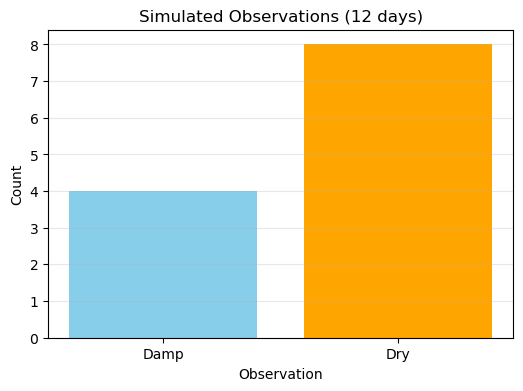

In [6]:
# Simulate a 12-day weather sequence
X_sim, Z_sim = model.sample(12)

# Convert one-hot encoded observations back to labels
sim_obs = [observations[int(x.argmax())] for x in X_sim]
sim_states = [states[int(z)] for z in Z_sim]

print("Simulated Observations:", sim_obs)
print("Simulated Hidden States:", sim_states)

# Bar chart of simulated observations
cnt = Counter(sim_obs)
plt.figure(figsize=(6,4))
plt.bar(cnt.keys(), cnt.values(), color=['skyblue','orange','green'])
plt.title('Simulated Observations (12 days)')
plt.xlabel('Observation')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

## 6. Stable Weather Model Comparison

In [7]:
A_stable = np.array([
    [0.90, 0.08, 0.02],
    [0.10, 0.80, 0.10],
    [0.02, 0.08, 0.90]
])

stable_model = hmm.MultinomialHMM(n_components=3, random_state=42, n_iter=1, n_trials=1)
stable_model.startprob_ = pi.copy()
stable_model.transmat_ = A_stable.copy()
stable_model.emissionprob_ = B.copy()

ll_original = model.score(obs_encoded)
ll_stable = stable_model.score(obs_encoded)

print(f"Log-likelihood (Original Model): {ll_original:.6f}")
print(f"Log-likelihood (Stable Model):   {ll_stable:.6f}")

if ll_original > ll_stable:
    print("\nObservation sequence fits better under the Original Model.")
else:
    print("\nObservation sequence fits better under the Stable Model.")

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Log-likelihood (Original Model): -5.376120
Log-likelihood (Stable Model):   -5.970865

Observation sequence fits better under the Original Model.


## 🧠 Observations

1. The **log-likelihood** value shows how well the model explains the observed sequence — higher means a better fit.  
2. The **Viterbi algorithm** gives the most probable hidden state sequence for the observed weather.  
3. The **simulated sequence** realistically reflects the transition probabilities, showing likely weather changes.  
4. The **stable model** transitions less often, simulating longer consistent weather conditions.  
5. Comparing log-likelihoods helps determine which model better fits the observation pattern.
